<a href="https://colab.research.google.com/github/natihbernan/rockpaperscissors/blob/master/Rock_Paper_Scissors_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rock Paper Scissors Classifier

Notebook ini dibuat untuk memenuhi syarat lulus kelas Belajar Machine Learning untuk Pemula oleh Dicoding

---
Dibuat oleh: I Dewa Gede Natih Bernan (https://www.dicoding.com/users/684735)

### Upload Dataset

In [ ]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2020-06-21 11:42:49--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  8.89MB/s    in 43s     

2020-06-21 11:43:33 (7.18 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



### Ekstrak File .zip

In [ ]:
import zipfile, os
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
print('Jumlah gambar batu    :', len(os.listdir('/tmp/rockpaperscissors/rock/')))
print('Jumlah gambar kertas  :', len(os.listdir('/tmp/rockpaperscissors/paper/')))
print('Jumlah gambar gunting :', len(os.listdir('/tmp/rockpaperscissors/scissors/')))

Jumlah gambar batu    : 726
Jumlah gambar kertas  : 712
Jumlah gambar gunting : 750


### Membuat Direktori Baru

In [ ]:
os.mkdir('/tmp/all-images/')
os.mkdir('/tmp/all-images/train/')
os.mkdir('/tmp/all-images/train/rock/')
os.mkdir('/tmp/all-images/train/paper/')
os.mkdir('/tmp/all-images/train/scissors/')
os.mkdir('/tmp/all-images/val/')
os.mkdir('/tmp/all-images/val/rock/')
os.mkdir('/tmp/all-images/val/paper/')
os.mkdir('/tmp/all-images/val/scissors/')

### Train Validation Split

In [ ]:
import random
from shutil import copyfile

def train_val_split(source, train, val, train_ratio):
  total_size = len(os.listdir(source))
  train_size = int(train_ratio * total_size)
  val_size = total_size - train_size

  randomized = random.sample(os.listdir(source), total_size)
  train_files = randomized[0:train_size]
  val_files = randomized[train_size:total_size]

  for i in train_files:
    i_file = source + i
    destination = train + i
    copyfile(i_file, destination)

  for i in val_files:
    i_file = source + i
    destination = val + i
    copyfile(i_file, destination)

train_ratio = 0.8

source_rock = '/tmp/rockpaperscissors/rock/'
train_rock = '/tmp/all-images/train/rock/'
val_rock = '/tmp/all-images/val/rock/'
train_val_split(source_rock, train_rock, val_rock, train_ratio)

source_paper = '/tmp/rockpaperscissors/paper/'
train_paper = '/tmp/all-images/train/paper/'
val_paper = '/tmp/all-images/val/paper/'
train_val_split(source_paper, train_paper, val_paper, train_ratio)

source_scissors = '/tmp/rockpaperscissors/scissors/'
train_scissors = '/tmp/all-images/train/scissors/'
val_scissors = '/tmp/all-images/val/scissors/'
train_val_split(source_scissors, train_scissors, val_scissors, train_ratio)

In [ ]:
print('Jumlah gambar batu train    :', len(os.listdir(train_rock)))
print('Jumlah gambar batu val      :', len(os.listdir(val_rock)))
print('Jumlah gambar kertas train  :', len(os.listdir(train_paper)))
print('Jumlah gambar kertas val    :', len(os.listdir(val_paper)))
print('Jumlah gambar gunting train :', len(os.listdir(train_scissors)))
print('Jumlah gambar gunting val   :', len(os.listdir(val_scissors)))

Jumlah gambar batu train    : 580
Jumlah gambar batu val      : 146
Jumlah gambar kertas train  : 569
Jumlah gambar kertas val    : 143
Jumlah gambar gunting train : 600
Jumlah gambar gunting val   : 150


### Augmentasi Gambar

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
                  rescale = 1./255.,
                  rotation_range = 30,
                  horizontal_flip = True,
                  shear_range = 0.3,
                  fill_mode = 'nearest',
                  width_shift_range = 0.2,
                  height_shift_range = 0.2,
                  zoom_range = 0.1
)

val_datagen = ImageDataGenerator(
                rescale = 1./255.,
                rotation_range = 30,
                horizontal_flip = True,
                shear_range = 0.3,
                fill_mode = 'nearest',
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                zoom_range = 0.1
)

In [ ]:
train_dir = '/tmp/all-images/train/'
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 5,
    class_mode = 'categorical'
)

val_dir = '/tmp/all-images/val/'
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (150, 150),
    batch_size = 5,
    class_mode = 'categorical'
)

Found 1749 images belonging to 3 classes.
Found 439 images belonging to 3 classes.


### Struktur Model Neural Network

In [ ]:
# callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.90):
      print('\nAkurasi mencapai 90%')
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
model = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
          tf.keras.layers.MaxPooling2D(2, 2),
          tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
          tf.keras.layers.MaxPooling2D(2, 2),
          tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
          tf.keras.layers.MaxPooling2D(2, 2),
          tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
          tf.keras.layers.MaxPooling2D(2, 2),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(512, activation = 'relu'),
          tf.keras.layers.Dense(3, activation = 'softmax')
])

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(learning_rate = 0.001),
              metrics = ['accuracy'])

### Fitting Model dengan Data

In [ ]:
history = model.fit(
            train_generator,
            steps_per_epoch = 30,
            epochs = 50,
            validation_data = val_generator,
            validation_steps = 5,
            verbose = 1,
            callbacks = [callbacks]
)

Epoch 1/50
30/30 [==============================] - 10s 326ms/step - loss: 1.1748 - accuracy: 0.3267 - val_loss: 1.0936 - val_accuracy: 0.4000
Epoch 2/50
30/30 [==============================] - 10s 317ms/step - loss: 1.1419 - accuracy: 0.3933 - val_loss: 1.1170 - val_accuracy: 0.2000
Epoch 3/50
30/30 [==============================] - 10s 318ms/step - loss: 1.1002 - accuracy: 0.4267 - val_loss: 1.0843 - val_accuracy: 0.4400
Epoch 4/50
30/30 [==============================] - 10s 317ms/step - loss: 1.0593 - accuracy: 0.4867 - val_loss: 0.9703 - val_accuracy: 0.6800
Epoch 5/50
30/30 [==============================] - 10s 318ms/step - loss: 0.9611 - accuracy: 0.5467 - val_loss: 0.8778 - val_accuracy: 0.6000
Epoch 6/50
30/30 [==============================] - 10s 317ms/step - loss: 0.8149 - accuracy: 0.6133 - val_loss: 0.7698 - val_accuracy: 0.7200
Epoch 7/50
30/30 [==============================] - 9s 316ms/step - loss: 0.7602 - accuracy: 0.6400 - val_loss: 0.9198 - val_accuracy: 0.6000


### Plot Akurasi dan Loss pada Train dan Validation Set

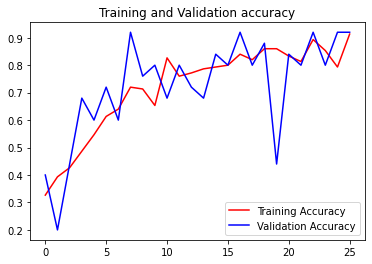

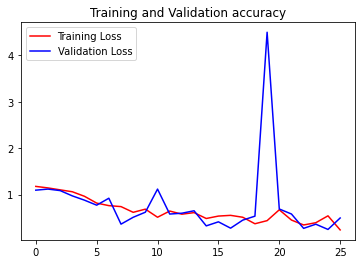

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend(loc = 'best')
plt.show()

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation accuracy')
plt.legend(loc = 'best')
plt.show()

### Prediksi Gambar Baru

Saving paper sample.jpg to paper sample.jpg
paper sample.jpg
paper


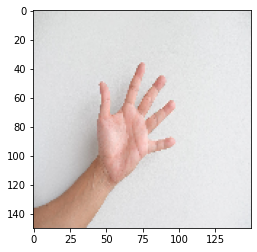

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size = (150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 5)

  print(fn)
  if classes[0,0] == 1.:
    print('paper')
  elif classes[0,1] == 1.:
    print('rock')
  else:
    print('scissors')